In [1]:
from importlib import reload
import sys
import pickle
import numpy as np 
import matplotlib as mpl
mpl.use('Agg')
import matplotlib.pyplot as plt
plt.ioff()
import seaborn as sns
import pandas as pd
from sklearn.cluster import AgglomerativeClustering
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
import pybedtools
from joblib import Parallel, delayed
from tqdm import tqdm
import time

# Data directories

In [2]:
genome_dir = '/home/braunger/masterthesis/data/genome_data/'
epigenome_dir = '/home/braunger/masterthesis/data/regulatory_data/regulatory_data_old_fibroblasts/'
processed_epigenome_data_dir = '/home/braunger/masterthesis/save/processed_regulatory_marks/processed_epigenome_data_old_fibroblasts_multiple_RNAseq/'
processed_hic_data_dir = '/home/braunger/masterthesis/save/processed_hic_data/processed_hic_data_old_fibroblasts/final_BP250000_intraKR_interINTERKR/'

In [3]:
cell_type = 'old_fibroblasts'
resol_str = '250kb'
resol = 250000
quality = 'MAPQGE30'

# Determine active and inactive regions

### Load epigenomic data

In [4]:
# collect normalized epigenomic data across all chromosomes into one dataframe
df_all_norm = pd.DataFrame()
chr_list =  np.arange(1,22+1)
for chrom in chr_list:
    df_chipseq_norm = pd.read_csv(processed_epigenome_data_dir+'features_matrix_chr'+str(chrom)+'_norm.csv', header=0, index_col = 0)
    df_chipseq_norm.columns = 'chr_'+str(chrom)+'_loc_'+np.array(df_chipseq_norm.columns)
    # Concatenate to data for previous chromosomes
    df_all_norm = pd.concat([df_all_norm, df_chipseq_norm],axis=1)
df_all_norm = df_all_norm.drop(["RNA-seq3"]) #because it is the same as RNA-seq
df_all_norm

,chr_1_loc_0,chr_1_loc_250000,chr_1_loc_500000,chr_1_loc_750000,chr_1_loc_1000000,chr_1_loc_1250000,chr_1_loc_1500000,chr_1_loc_1750000,chr_1_loc_2000000,chr_1_loc_2250000,...,chr_22_loc_49000000,chr_22_loc_49250000,chr_22_loc_49500000,chr_22_loc_49750000,chr_22_loc_50000000,chr_22_loc_50250000,chr_22_loc_50500000,chr_22_loc_50750000,chr_22_loc_51000000,chr_22_loc_51250000
DNase-seq,0.269464,-3.711076,0.269464,0.269464,0.269464,0.269464,0.269464,0.269464,0.269464,0.269464,...,0.269464,0.269464,0.269464,0.269464,0.269464,0.269464,0.269464,0.269464,0.269464,-3.711076
EZH2,-0.444723,-0.444723,-0.444723,2.248592,2.248592,-0.444723,2.248592,2.248592,2.248592,2.248592,...,-0.444723,-0.444723,2.248592,2.248592,2.248592,-0.444723,2.248592,-0.444723,-0.444723,-0.444723
EZH2phosphoT487,-0.769395,-0.769395,-0.769395,1.299722,1.299722,-0.769395,1.299722,-0.769395,1.299722,1.299722,...,-0.769395,-0.769395,-0.769395,1.299722,1.299722,-0.769395,-0.769395,-0.769395,-0.769395,-0.769395
H2AFZ,-1.475669,-1.475669,-1.475669,1.209104,1.255874,1.159805,1.159805,0.623855,1.255874,0.420390,...,-1.475669,-1.475669,-0.843649,0.993562,0.527786,0.790097,1.342779,-0.211630,-1.475669,-1.475669
H3F3A,-0.820471,-1.325952,-1.325952,0.544549,0.276384,1.178298,1.201451,1.307326,1.245662,0.093112,...,-1.325952,-1.325952,-1.325952,-0.524784,0.598592,0.353218,0.486177,0.781864,-0.314991,-1.325952
H3K27ac,-1.269876,-1.269876,-1.269876,1.207043,0.431324,1.508518,1.432448,1.611489,1.349124,1.207043,...,-1.269876,-1.269876,-1.269876,0.826469,-0.057917,1.037303,0.826469,-0.663896,-1.269876,-1.269876
H3K27me3,-0.906839,-0.906839,-0.906839,1.127065,1.075248,-0.386244,0.301943,1.019588,1.221070,1.343131,...,-0.906839,-0.906839,0.743406,0.554654,1.622197,-0.906839,0.822537,-0.906839,-0.906839,-0.906839
H3K46me3,-0.808300,-0.808300,-0.808300,-0.321648,0.808324,1.422982,1.707656,1.044558,-0.036975,0.557905,...,-0.808300,-0.808300,-0.808300,-0.808300,1.044558,0.875240,0.936330,1.221003,-0.808300,-0.808300
H3K4me1,-1.464451,-1.464451,-1.464451,0.786347,0.097906,1.011826,0.823005,0.923332,1.090987,1.011826,...,-1.464451,-1.464451,-1.464451,0.265562,0.186401,0.747809,0.462685,-0.943665,-1.464451,-1.464451
H3K4me2,-1.454666,-1.454666,-1.454666,1.335215,1.335215,1.463855,1.184099,1.184099,1.493238,1.050492,...,-1.454666,-1.454666,-0.853898,0.948407,0.699065,1.097354,1.401919,-0.502471,-1.454666,-1.454666


### Correlation of RNA-seq data

In [5]:
df_all_norm.T.corr()

,DNase-seq,EZH2,EZH2phosphoT487,H2AFZ,H3F3A,H3K27ac,H3K27me3,H3K46me3,H3K4me1,H3K4me2,H3K4me3,H3K79me2,H3K9ac,H3K9me2,H3K9me3,H4K20me1,RNA-seq,RNA-seq2
DNase-seq,1.000000,0.110544,0.200899,0.378402,0.354552,0.332838,0.231575,0.214160,0.385884,0.378473,0.350314,0.211644,0.306715,0.167871,0.099160,0.145425,0.181683,0.183871
EZH2,0.110544,1.000000,0.264043,0.160132,0.116321,0.075688,0.508844,0.115907,0.093723,0.168629,0.218217,0.084543,0.127854,-0.129003,-0.129117,0.085288,0.161802,0.162659
EZH2phosphoT487,0.200899,0.264043,1.000000,0.456786,0.328675,0.481455,0.262791,0.187366,0.517588,0.528781,0.501719,0.268803,0.459337,0.102620,-0.139855,0.136663,0.171428,0.172602
H2AFZ,0.378402,0.160132,0.456786,1.000000,0.555208,0.848808,0.263426,0.357728,0.877471,0.904049,0.878833,0.528222,0.836184,0.187942,-0.234672,0.239984,0.333655,0.336982
H3F3A,0.354552,0.116321,0.328675,0.555208,1.000000,0.588535,0.247126,0.675040,0.614421,0.610417,0.573145,0.427993,0.568694,0.067282,-0.177122,0.526212,0.591986,0.597905
H3K27ac,0.332838,0.075688,0.481455,0.848808,0.588535,1.000000,0.167002,0.417965,0.936809,0.940535,0.894233,0.704443,0.928465,0.117204,-0.236454,0.306635,0.380219,0.383004
H3K27me3,0.231575,0.508844,0.262791,0.263426,0.247126,0.167002,1.000000,0.158817,0.260503,0.287412,0.280612,0.077209,0.187499,-0.119607,-0.223701,0.120497,0.175587,0.178940
H3K46me3,0.214160,0.115907,0.187366,0.357728,0.675040,0.417965,0.158817,1.000000,0.397187,0.414852,0.419330,0.429689,0.430961,-0.070354,-0.111071,0.650510,0.743135,0.748119
H3K4me1,0.385884,0.093723,0.517588,0.877471,0.614421,0.936809,0.260503,0.397187,1.000000,0.955100,0.877473,0.633260,0.874221,0.192293,-0.265690,0.289145,0.344693,0.347907
H3K4me2,0.378473,0.168629,0.528781,0.904049,0.610417,0.940535,0.287412,0.414852,0.955100,1.000000,0.939983,0.663252,0.917491,0.135859,-0.261457,0.300846,0.380100,0.382908


### Visualize features as heatmap

<Figure size 432x288 with 0 Axes>

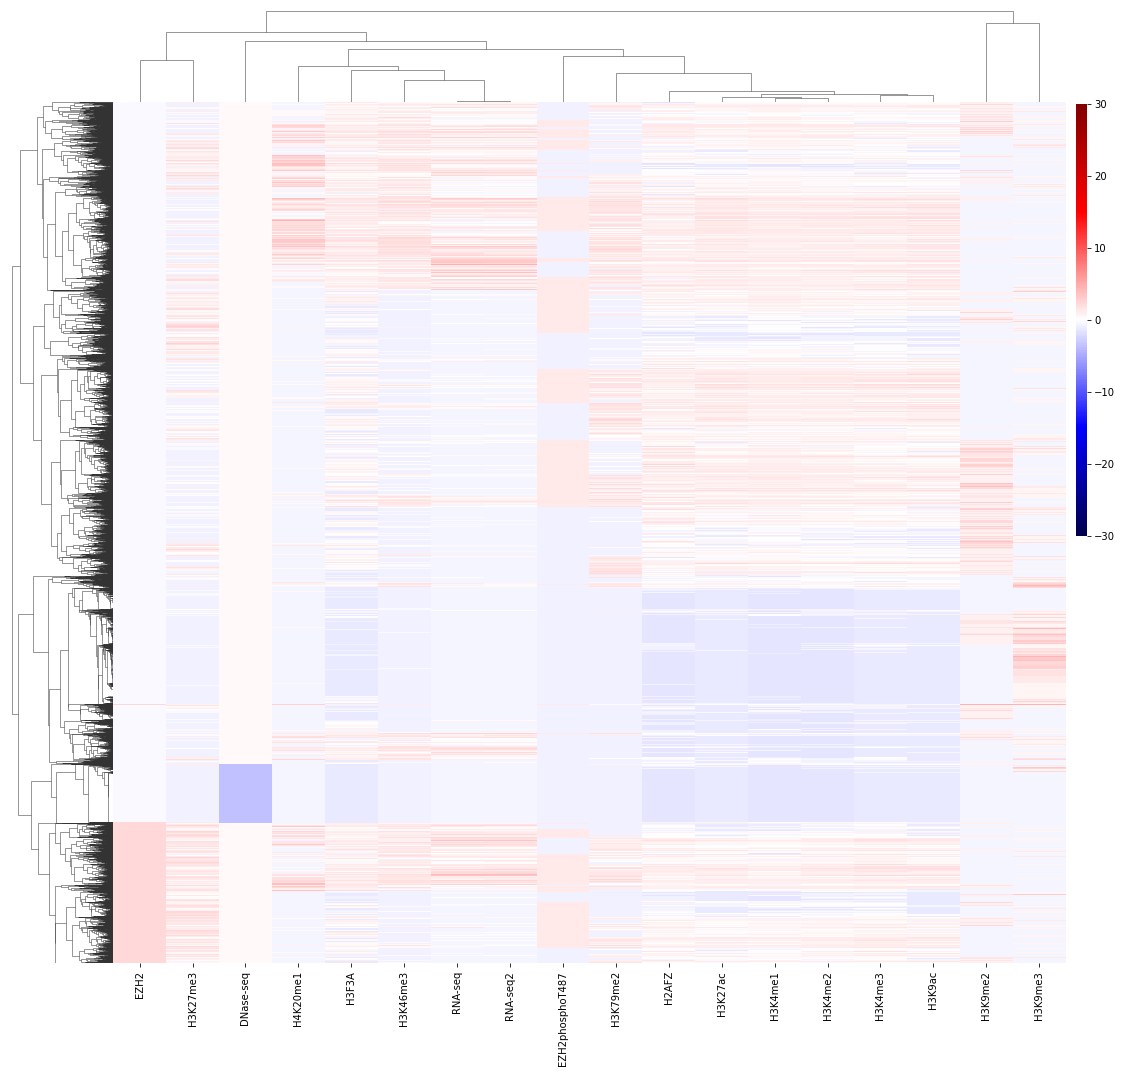

In [16]:
plt.figure()
sns.clustermap(df_all_norm.T,
               method='average',
               metric='correlation',
               row_cluster=True, col_cluster=True,
               figsize=(15,15),
               xticklabels=True, yticklabels=False,
               cmap='seismic', cbar_pos=(1, 0.5, 0.01, .4),
               vmin=-30, vmax=30,
               dendrogram_ratio=(.1, .1))
plt.show()

### Hierarchical clustering

In [7]:
# Hierarchical clustering
clustering = AgglomerativeClustering(n_clusters=2, affinity='euclidean', linkage='ward').fit(df_all_norm.T)
print('Total number of loci = '+str(len(clustering.labels_)))
print('Number of loci in cluster 0 = '+str(np.sum(clustering.labels_==0)))
print('Number of loci in cluster 1 = '+str(np.sum(clustering.labels_==1)))

Total number of loci = 11537
Number of loci in cluster 0 = 7725
Number of loci in cluster 1 = 3812


### PCA

In [8]:
# PCA
pca = PCA(n_components=2)
PCs = pca.fit_transform(df_all_norm.T)

In [9]:
# Add cluster to data
df_clusters = df_all_norm.T
df_clusters['cluster'] = clustering.labels_
df_clusters['PC1'] = PCs[:,0]
df_clusters['PC2'] = PCs[:,1]
df_clusters.head()

,DNase-seq,EZH2,EZH2phosphoT487,H2AFZ,H3F3A,H3K27ac,H3K27me3,H3K46me3,H3K4me1,H3K4me2,...,H3K79me2,H3K9ac,H3K9me2,H3K9me3,H4K20me1,RNA-seq,RNA-seq2,cluster,PC1,PC2
chr_1_loc_0,0.269464,-0.444723,-0.769395,-1.475669,-0.820471,-1.269876,-0.906839,-0.808300,-1.464451,-1.454666,...,-0.811035,-1.178289,-0.687506,-0.638900,-0.55511,0.310529,0.086797,1,-3.410731,1.239081
chr_1_loc_250000,-3.711076,-0.444723,-0.769395,-1.475669,-1.325952,-1.269876,-0.906839,-0.808300,-1.464451,-1.454666,...,-0.811035,-1.178289,-0.687506,-0.638900,-0.55511,-0.531290,-0.197488,1,-4.371185,0.906756
chr_1_loc_500000,0.269464,-0.444723,-0.769395,-1.475669,-1.325952,-1.269876,-0.906839,-0.808300,-1.464451,-1.454666,...,-0.811035,-1.178289,-0.687506,-0.638900,-0.55511,0.809652,0.977663,1,-3.241324,1.765901
chr_1_loc_750000,0.269464,2.248592,1.299722,1.209104,0.544549,1.207043,1.127065,-0.321648,0.786347,1.335215,...,1.336700,1.647474,-0.687506,-0.638900,-0.55511,2.039349,1.767159,0,4.337308,0.050972
chr_1_loc_1000000,0.269464,2.248592,1.299722,1.255874,0.276384,0.431324,1.075248,0.808324,0.097906,1.335215,...,1.035413,1.464025,-0.687506,0.592671,-0.55511,2.274694,2.281589,0,3.969412,1.110354


### Plot clusters

<AxesSubplot:xlabel='PC1', ylabel='PC2'>

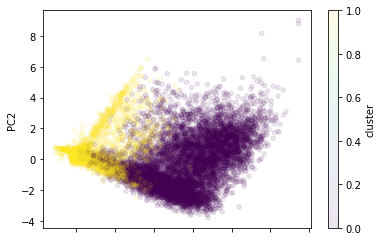

In [10]:
# Plot PC1 and PC2
%matplotlib inline
df_clusters.plot.scatter(x='PC1', y='PC2', c='cluster', colormap='viridis', alpha=0.1)

### Plot histogram of features

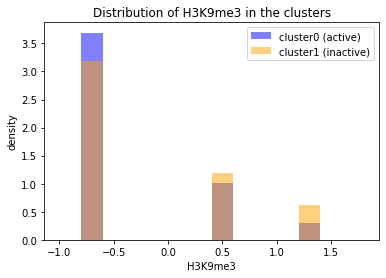

In [11]:
# Distribution of H3K9me3 in clusters
%matplotlib inline
plt.figure()
plt.hist(df_clusters.loc[df_clusters['cluster']==0]['H3K9me3'], bins=np.arange(-1,2,0.2), 
         color='blue', alpha=0.5, density=True, label='cluster0 (active)')
plt.hist(df_clusters.loc[df_clusters['cluster']==1]['H3K9me3'], bins=np.arange(-1,2,0.2), 
         color='orange', alpha=0.5, density=True, label='cluster1 (inactive)')

plt.xlabel('H3K9me3')
plt.ylabel('density')
plt.title('Distribution of H3K9me3 in the clusters')
plt.legend(loc='upper right')
plt.show()

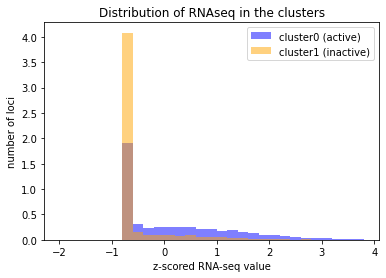

In [12]:
# Distribution of RNAseq in clusters
%matplotlib inline
plt.figure()
plt.hist(df_clusters.loc[df_clusters['cluster']==0]['RNA-seq'], bins=np.arange(-2,4,0.2), 
         color='blue', alpha=0.5, density=True, label='cluster0 (active)')
plt.hist(df_clusters.loc[df_clusters['cluster']==1]['RNA-seq'], bins=np.arange(-2,4,0.2), 
         color='orange', alpha=0.5, density=True, label='cluster1 (inactive)')
#plt.yscale("log")
plt.xlabel('z-scored RNA-seq value')
plt.ylabel('number of loci')
plt.title('Distribution of RNAseq in the clusters')
plt.legend(loc='upper right')
plt.show()

In [13]:
# Define active loci as loci in cluster 0
active_loci = list(df_clusters[df_clusters['cluster']==0].index)
print(len(active_loci))
print(active_loci[0:10])

7725
['chr_1_loc_750000', 'chr_1_loc_1000000', 'chr_1_loc_1250000', 'chr_1_loc_1500000', 'chr_1_loc_1750000', 'chr_1_loc_2000000', 'chr_1_loc_2250000', 'chr_1_loc_2500000', 'chr_1_loc_3000000', 'chr_1_loc_3250000']


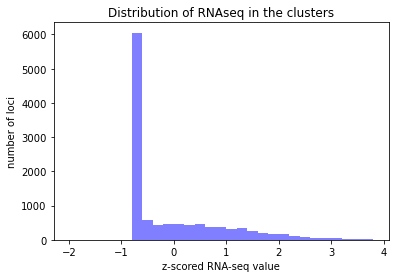

In [14]:
%matplotlib inline
plt.figure()
plt.hist(df_clusters['RNA-seq'], bins=np.arange(-2,4,0.2), 
         color='blue', alpha=0.5, density=False)

plt.xlabel('z-scored RNA-seq value')
plt.ylabel('number of loci')
plt.title('Distribution of RNAseq in the clusters')
plt.show()

/home/braunger/miniconda3/envs/hic/lib/python3.9/site-packages/seaborn/matrix.py:654: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)


<Figure size 432x288 with 0 Axes>

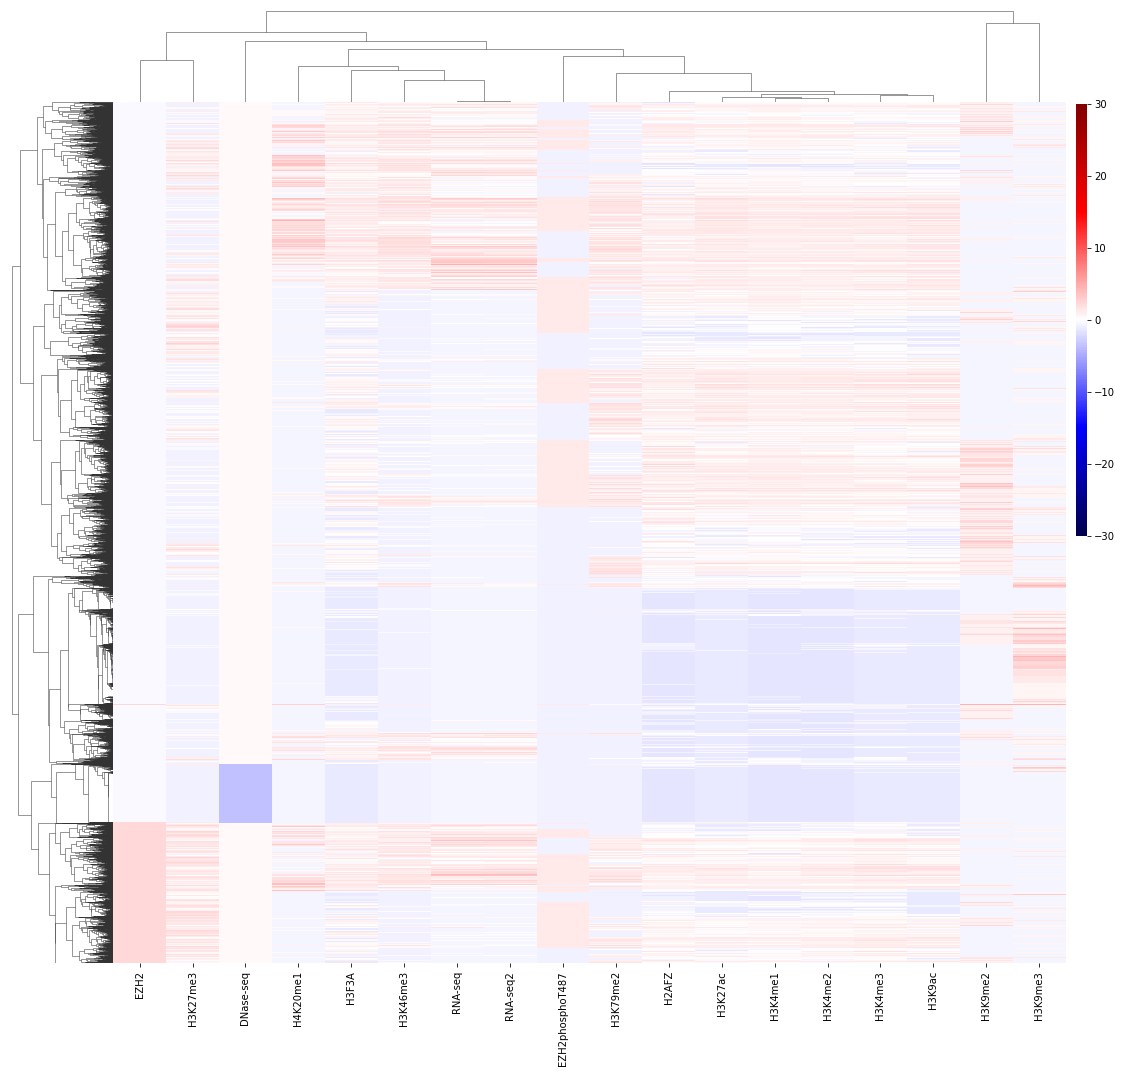

In [15]:
plt.figure()
sns.clustermap(df_all_norm.T,
               method='average',
               metric='correlation',
               row_cluster=True, col_cluster=True,
               figsize=(15,15),
               xticklabels=True, yticklabels=False,
               cmap='seismic', cbar_pos=(1, 0.5, 0.01, .4),
               vmin=-30, vmax=30,
               dendrogram_ratio=(.1, .1))
plt.show()

<AxesSubplot:>

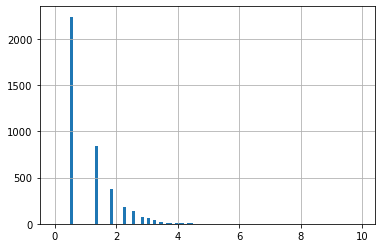

In [73]:
df_all_norm.loc['H3K9me3'].hist(bins=np.arange(0,10,0.1))